# EdU-RB image Analysis
Pulling Images from screening data from Omero.
Segmentation via Stardist.
Display a sample image to check segmentation.
Loop through the plate and collect Features from Feature list (label, area, mean and max intensities)
Return Padnas dataframe with single cell data sorted by row and column.
Filter out smallest objects (<=50 pixels area)
Save as CSV file in Datafolder

In [4]:
#Define Variables
# 1) Name of Datafolder -> Experiment
Experiment='220408_XM_EdURBtest01'
# 2) Location where to save Data -> PD
PD='/Users/hh65/Desktop'
# 3) Sample Image ID -> ID
ID=294861
# 4) Plate ID -> PlateID
PlateID=660

In [36]:
# Imports and Functions

import os
from omero.gateway import BlitzGateway
import numpy as np
import napari
import pandas as pd
from scipy import ndimage as ndi
from skimage import measure
from skimage.segmentation import clear_border
from skimage.morphology import remove_small_objects

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns
import matplotlib.pyplot as plt

from stardist.models import StarDist2D
from csbdeep.utils import normalize
model = StarDist2D.from_pretrained('2D_versatile_fluo')

# Make folder to save output data in chosen directory

D_PATH = os.path.join(PD, Experiment)
os.makedirs(D_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="pdf", resolution=300):
    path = os.path.join(D_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


def Stardist_Segmentation(image):
    """
    Perform Stardist Segmentation,
    :param image: Image to Segment
    :return: Segmented Objects and Labels
    """
    label_objects, nb_labels = model.predict_instances(normalize(image))
    cleared = remove_small_objects(clear_border(label_objects), 10)
    segmented_cells, cell_number = ndi.label(cleared)
    return segmented_cells, cell_number

def make_bbox(bbox_extents):
    """Get the coordinates of the corners of a
    bounding box from the extents

    Parameters
    ----------
    bbox_extents : list (4xN)
        List of the extents of the bounding boxes for each of the N regions.
        Should be ordered: [min_row, min_column, max_row, max_column]

    Returns
    -------
    bbox_rect : np.ndarray
        The corners of the bounding box. Can be input directly into a
        napari Shapes layer.
    """
    minr = bbox_extents[0]
    minc = bbox_extents[1]
    maxr = bbox_extents[2]
    maxc = bbox_extents[3]

    bbox_rect = np.array(
        [[minr, minc], [maxr, minc], [maxr, maxc], [minr, maxc]]
    )
    bbox_rect = np.moveaxis(bbox_rect, 2, 0)

    return bbox_rect

def Napari_Display(image, segmented_cells, cell_number):
    """

    Display Image in Napari Viewer. Segmented cells and rectangles around segmented cells
   :param image: Image, Segmented Cells, and Cell Number
    """
    properties = measure.regionprops_table(
        segmented_cells, properties=('label', 'bbox')
    )
    # create the bounding box rectangles
    bbox_rects = make_bbox([properties[f'bbox-{i}'] for i in range(4)])

    viewer=napari.Viewer()
    viewer.add_image(image)
    viewer.add_labels(segmented_cells, name=f'segmentation {cell_number} of cells')
    viewer.add_shapes(
        bbox_rects,
        face_color='transparent',
        edge_color='orange',
        properties=properties,
        name='bounding box',
    )


def get_features(label_image, image, featurelist):
    """
    Generate dataframe with single cell data of selected features for segmented image
    :param label_image: segmented imageg from watershed
    :param image: original image
    :param featurelist: list of measured features e.g.['area','max_intensity','mean_intensity']
    :return: dataframe with single cell features
    """
    props = measure.regionprops_table(label_image, image, properties=featurelist)
    data = pd.DataFrame(props)
    return data

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [37]:
# Connecting to server

conn = BlitzGateway('helfrid', 'Omero_21', host='omero.lifesci.sussex.ac.uk')
conn.connect()




True

In [38]:

object= conn.getObject("Image", ID)
pixels=object.getPrimaryPixels()

imgDAPI=pixels.getPlane(0,0,0)
segmented_cells, cell_number=Stardist_Segmentation(imgDAPI)
Napari_Display(imgDAPI, segmented_cells, cell_number)

2022-04-19 12:03:27.271224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
numeric.py (2446): elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [39]:
# Loop through the Well and analyse Images.Return a dataframe df_sc with singel cell data
from tqdm import tqdm
Feature_list=['label','area','max_intensity','mean_intensity']
df_sc=pd.DataFrame()
plate = conn.getObject("Plate", PlateID)
plate_name= plate.getName()
wells = list(plate.listChildren())
for well in tqdm(wells):
    print (well.id)
    df=pd.DataFrame()
    for number, image in enumerate(well.listChildren()):
        image = well.getImage(number)
        pixels=image.getPrimaryPixels()
        DAPI=pixels.getPlane(0,0,0)
        EdU=pixels.getPlane(0,1,0)
        RB=pixels.getPlane(0,2,0)

        segmented, cell_number = Stardist_Segmentation(DAPI)
        DAPI_data=get_features(segmented, DAPI, Feature_list)
        DAPI_data.rename(columns = {'max_intensity':'max_intensity_DAPI',
                                    'mean_intensity':'mean_intensity_DAPI'}, inplace = True)

        EdU_data=get_features(segmented, EdU, Feature_list)
        EdU_data.rename(columns = {'max_intensity':'max_intensity_EdU',
                                    'mean_intensity':'mean_intensity_EdU'}, inplace = True)
        RB_data=get_features(segmented, RB, Feature_list)
        RB_data.rename(columns = {'max_intensity':'max_intensity_RB',
                                    'mean_intensity':'mean_intensity_RB'}, inplace = True)
        df_merge_2 = pd.merge(DAPI_data, EdU_data, on=['label','area'])
        df_merge_3 = pd.merge(df_merge_2, RB_data, on=['label','area'])
        df=pd.concat([df,df_merge_3])
        df['column']=well.column
        df['row']=well.row
        df['integrated_int_DAPI']=df['mean_intensity_DAPI']*df['area']
    df_sc=pd.concat([df_sc,df])

df_sc.info()

  0%|          | 0/15 [00:00<?, ?it/s]

4695


  7%|▋         | 1/15 [00:12<02:52, 12.34s/it]

4694


 13%|█▎        | 2/15 [00:21<02:15, 10.44s/it]

4693


 20%|██        | 3/15 [00:30<01:57,  9.83s/it]

4692


 27%|██▋       | 4/15 [00:41<01:53, 10.29s/it]

4691


 33%|███▎      | 5/15 [00:51<01:41, 10.18s/it]

4690


 40%|████      | 6/15 [01:02<01:33, 10.34s/it]

4689


 47%|████▋     | 7/15 [01:12<01:21, 10.22s/it]

4688


 53%|█████▎    | 8/15 [01:20<01:08,  9.76s/it]

4687


 60%|██████    | 9/15 [01:31<00:59,  9.90s/it]

4686


 67%|██████▋   | 10/15 [01:40<00:48,  9.75s/it]

4685


 73%|███████▎  | 11/15 [01:51<00:40, 10.09s/it]

4684


 80%|████████  | 12/15 [02:01<00:29, 10.00s/it]

4683


 87%|████████▋ | 13/15 [02:14<00:22, 11.02s/it]

4682


 93%|█████████▎| 14/15 [02:23<00:10, 10.52s/it]

4681


100%|██████████| 15/15 [02:35<00:00, 10.36s/it]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29152 entries, 0 to 1579
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   label                29152 non-null  int64  
 1   area                 29152 non-null  int64  
 2   max_intensity_DAPI   29152 non-null  float64
 3   mean_intensity_DAPI  29152 non-null  float64
 4   max_intensity_EdU    29152 non-null  float64
 5   mean_intensity_EdU   29152 non-null  float64
 6   max_intensity_RB     29152 non-null  float64
 7   mean_intensity_RB    29152 non-null  float64
 8   column               29152 non-null  int64  
 9   row                  29152 non-null  int64  
 10  integrated_int_DAPI  29152 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 2.7 MB


<AxesSubplot:title={'center':'All nuclei'}, xlabel='integrated_int_DAPI', ylabel='area'>

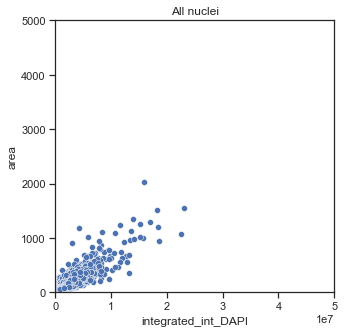

In [40]:
sns.set(style='ticks', font='Arial')
fig, ax = plt.subplots(ncols=1,figsize=(5, 5))
ax.set_xlim([0,50000000])
ax.set_ylim([0,5000])
plt.title('All nuclei')
sns.scatterplot(data=df_sc,x='integrated_int_DAPI',y='area')


In [41]:
df_gn=df_sc[df_sc['area']>50]
df_gn=df_gn.reset_index(drop=True)
df_gn=df_gn.sort_values(['row','column'])
csv_path=os.path.join(D_PATH, 'EdURB_test01.csv')
df_gn.to_csv(csv_path)